# Bayesian Optimization of CNN with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up a simple CNN
- Set up the hyperparameter search shape
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [4]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [8]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [9]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

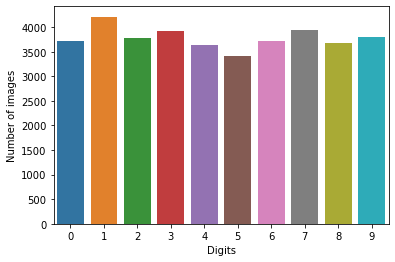

In [11]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [12]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [13]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [14]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

In [15]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

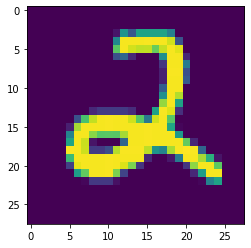

In [16]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

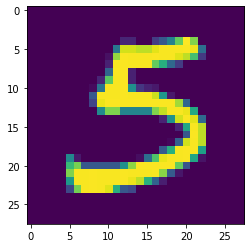

In [17]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers.

In fact, the number of fully-connected Dense layers and the number of Neurons in each one of the Dense layers, are some of the hyperparameters we want to optimize.

We could also optimize the number of Convolutional layers. But we will keep that for later, and here we keep it a bit simpler.

In [18]:
# function to create the CNN

def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function only.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [19]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [20]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

# Define the Objective Function

In [21]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [22]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [23]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

266/266 [==============================] - 13s 48ms/step - loss: 2.2708 - accuracy: 0.1641 - val_loss: 2.2362 - val_accuracy: 0.2542 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 20s 73ms/step - loss: 2.1738 - accuracy: 0.3544 - val_loss: 2.0960 - val_accuracy: 0.4228 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 12s 46ms/step - loss: 1.9822 - accuracy: 0.4479 - val_

-0.47777777910232544

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization

In [24]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

266/266 [==============================] - 14s 51ms/step - loss: 2.2683 - accuracy: 0.1828 - val_loss: 2.2260 - val_accuracy: 0.3071 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 13s 48ms/step - loss: 2.1734 - accuracy: 0.3757 - val_loss: 2.1073 - val_accuracy: 0.4246 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 15s 58ms/step - loss: 2.0243 - accuracy: 0.4534 - val_

266/266 [==============================] - 13s 50ms/step - loss: 2.3133 - accuracy: 0.1041 - val_loss: 2.3031 - val_accuracy: 0.1146 - lr: 7.8421e-05
Epoch 2/3
266/266 [==============================] - 13s 48ms/step - loss: 2.3032 - accuracy: 0.1062 - val_loss: 2.3020 - val_accuracy: 0.1146 - lr: 7.8421e-05
Epoch 3/3
265/266 [============================>.] - ETA: 0s - loss: 2.3038 - accuracy: 0.1055
Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.9210481190821156e-05.
266/266 [==============================] - 17s 63ms/step - loss: 2.3038 - accuracy: 0.1055 - val_loss: 2.3012 - val_accuracy: 0.1146 - lr: 7.8421e-05

Accuracy: 11.46%

learning rate: 7.6e-04
num_dense_layers: 3
num_dense_nodes: 277
activation: sigmoid

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, ca

Epoch 3/3
266/266 [==============================] - 14s 51ms/step - loss: 1.2895 - accuracy: 0.4248 - val_loss: 1.2984 - val_accuracy: 0.4053 - lr: 0.0100

Accuracy: 40.53%

learning rate: 1.0e-06
num_dense_layers: 5
num_dense_nodes: 512
activation: relu

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

266/266 [==============================] - 18s 69ms/step - loss: 2.2942 - accuracy: 0.1486 - val_loss: 2.2865 - val_accuracy: 0.2323 - lr: 1.0000e-06
Epoch 2/3
266/266 [==============================] - 16s 61ms/step - loss: 2.2746 - accurac

266/266 [==============================] - 15s 55ms/step - loss: 0.3461 - accuracy: 0.8932 - val_loss: 0.1190 - val_accuracy: 0.9656 - lr: 5.4126e-04
Epoch 2/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0923 - accuracy: 0.9709 - val_loss: 0.0803 - val_accuracy: 0.9767 - lr: 5.4126e-04
Epoch 3/3
266/266 [==============================] - 15s 58ms/step - loss: 0.0626 - accuracy: 0.9802 - val_loss: 0.0977 - val_accuracy: 0.9733 - lr: 5.4126e-04

Accuracy: 97.33%

learning rate: 2.7e-04
num_dense_layers: 4
num_dense_nodes: 512
activation: relu

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disab


Accuracy: 97.06%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 512
activation: sigmoid

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

266/266 [==============================] - 16s 58ms/step - loss: 2.4942 - accuracy: 0.1034 - val_loss: 2.3388 - val_accuracy: 0.0868 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 15s 57ms/step - loss: 2.3893 - accuracy: 0.0997 - val_loss: 2.3278 - val_accuracy: 0.0971 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 16s 61ms/step - loss: 2.4188 - accuracy

# Analyze results

In [25]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9796'

In [26]:
gp_.x

[0.0003772321497313436, 4, 477, 'relu']

In [27]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [28]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- learning rate=0.000377
- num_dense_layers=4
- num_nodes=477
- activation = relu


## Convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

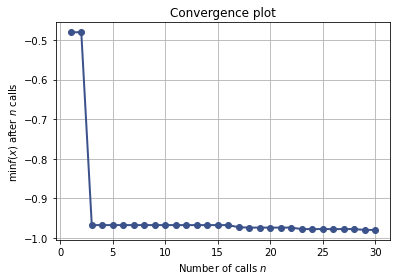

In [29]:
plot_convergence(gp_)

## Partially dependency plots

[plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)

In [30]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

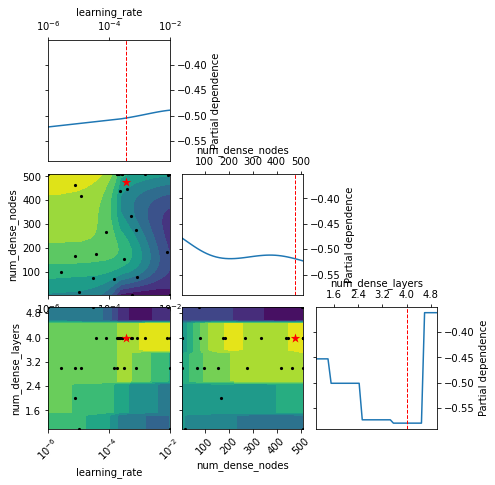

In [31]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

## Evaluation order

[plot_evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html)

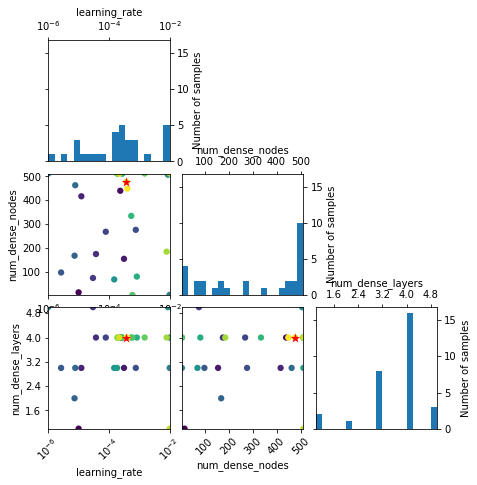

In [32]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

# Evaluate the model

In [33]:
# load best model

model = load_model(path_best_model)

In [34]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 7ms/step - loss: 0.0691 - accuracy: 0.9776


In [35]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06908618658781052
accuracy 0.9776190519332886


## Confusion matrix

In [36]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[418,   0,   1,   1,   0,   0,   1,   0,   1,   0],
       [  0, 468,   2,   0,   0,   0,   1,   1,   1,   0],
       [  2,   1, 404,   1,   0,   0,   0,   1,   0,   0],
       [  2,   0,   3, 418,   0,   1,   0,   1,   1,   0],
       [  1,   3,   0,   0, 422,   0,   1,   0,   0,   2],
       [  0,   0,   0,   4,   0, 373,   4,   0,   1,   0],
       [  0,   0,   1,   0,   2,   0, 409,   0,   0,   0],
       [  0,   2,   6,   1,   0,   2,   0, 456,   0,   2],
       [  0,   3,   3,   5,   1,   1,   9,   0, 362,   0],
       [  4,   0,   0,   4,   9,   0,   0,   1,   0, 376]])

Text(0.5, 13.421126458070283, 'Predicted label')

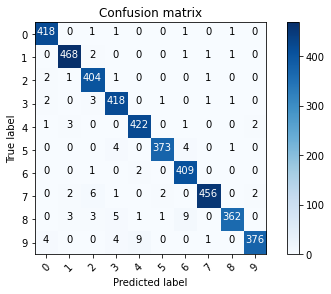

In [37]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

#  References

This notebook was based on these resources:

- [TensorFlow Tutorial #19](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)
- [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
- [Keras](https://keras.io/)